In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import pickle
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


### 近似求导

In [2]:
def f(x):
    return 3. * x ** 2 + 2. * x - 1

def approximate_derivative(f, x, eps=1e-3):
    return (f(x + eps) - f(x - eps)) / (2. * eps)

print(approximate_derivative(f, 1.))

7.999999999999119


In [17]:
def g(x1, x2):
    return (x1 + 5) * (x2 ** 2)

def approximate_gradient(g, x1, x2, eps=1e-3):
#     固定一个的取值，求另一个的偏导数
    dg_x1 = approximate_derivative(lambda x: g(x, x2), x1, eps)
    dg_x2 = approximate_derivative(lambda x: g(x1, x), x2, eps)
    return dg_x1, dg_x2

print(approximate_gradient(g, 2., 3.))
    

(8.999999999993236, 41.999999999994486)


## tf中的求导

tf.GradientTape(
    persistent=False, watch_accessed_variables=True
)

Trainable variables (created by tf.Variable or tf.compat.v1.get_variable, where trainable=True is default in both cases) are automatically watched. Tensors can be manually watched by invoking the watch method on this context manager.

In [5]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
print(dz_x1)

try:
    dz_x2 = tape.gradient(z, x2)
except RuntimeError as ex:
    print(ex)

tf.Tensor(9.0, shape=(), dtype=float32)
GradientTape.gradient can only be called once on non-persistent tapes.


上面的tape在求了一次偏导数之后，再次调用报错，因为默认只能调用一次，如果需要多次进行调用，需要设置参数:persistent=True

By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computation, create a persistent gradient tape. This allows multiple calls to the gradient() method as resources are released when the tape object is garbage collected. For example:

persistent	Boolean controlling whether a persistent gradient tape is created. False by default, which means at most one call can be made to the gradient() method on this object.

In [13]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as gt:
    gt.watch(x)
    y = x * x
    z = y * y
dz_dx = gt.gradient(z, x)  # (4*x^3 at x = 3)
print(dz_dx)

dy_dx = gt.gradient(y, x)
print(dy_dx)

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


In [18]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as tape:
    z = g(x1,x2)
    
dz_x1 = tape.gradient(z, x1)
dz_x2 = tape.gradient(z, x2)
print(dz_x1, dz_x2)

del tape

tf.Tensor(9.0, shape=(), dtype=float32) tf.Tensor(42.0, shape=(), dtype=float32)


In [19]:
# 同时求偏导
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)
    
dz_x1x2 = tape.gradient(z, [x1, x2])

print(dz_x1x2)

[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=42.0>]


In [20]:
# 对常量求导数
x1 = tf.constant(2.0)
x2 = tf.constant(3.0)
with tf.GradientTape() as tape:
    z = g(x1, x2)

dz_x1x2 = tape.gradient(z, [x1, x2])

print(dz_x1x2)

[None, None]


### watch(tensor)
Ensures that tensor is being traced by this tape.

In [21]:
x1 = tf.constant(2.0)
x2 = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x1)
    tape.watch(x2)
    z = g(x1, x2)

dz_x1x2 = tape.gradient(z, [x1, x2])

print(dz_x1x2)

[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=42.0>]


In [22]:
# 多个函数同时对一个变量求导, 分别求出导数再相加
x = tf.Variable(5.0)
with tf.GradientTape() as tape:
    z1 = 3 * x
    z2 = x ** 2

tape.gradient([z1, z2], x)

<tf.Tensor: shape=(), dtype=float32, numpy=13.0>

In [23]:
# 高阶偏导
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape(persistent=True) as inner_tape:
        z = g(x1, x2)
    inner_grads = inner_tape.gradient(z, [x1, x2])
outer_grads = [outer_tape.gradient(inner_grad, [x1, x2]) for inner_grad in inner_grads]

print(outer_grads)
del outer_tape
del inner_tape

[[None, <tf.Tensor: shape=(), dtype=float32, numpy=6.0>], [<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=14.0>]]


In [44]:
# 模拟梯度下降算法
learning_rate = 0.1
x = tf.Variable(0.0)

for _ in range(100):
    with tf.GradientTape() as tape:
#       f(x) = 3. * x ** 2 + 2. * x - 1
        z = f(x)
    dz_dx = tape.gradient(z, x)
    x.assign_sub(learning_rate * dz_dx)
print(x)


<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>


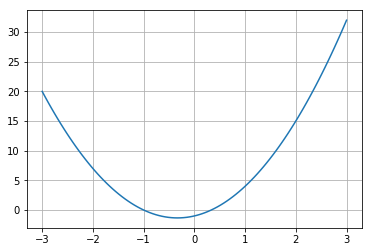

In [43]:
# 绘制函数图像观察
x_points = np.linspace(-3,3,100)
y = [3. * _x ** 2 + 2. * _x -1 for _x in x_points]
plt.plot(x_points,y)
plt.grid(True)

In [46]:
# GradientTape与optimizer的结合使用
learning_rate = 0.1
x = tf.Variable(0.0)

optimizer = keras.optimizers.SGD(lr = learning_rate)

for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z, x)
    optimizer.apply_gradients([(dz_dx, x)]) # 使用keras中的optimizer对x进行更新
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>


apply_gradients(
    grads_and_vars, name=None, experimental_aggregate_gradients=True
)
grads_and_vars	List of (gradient, variable) pairs.

In [ ]:
grads = tape.gradient(loss, vars)
grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
# Processing aggregated gradients.
optimizer.apply_gradients(zip(grads, vars),
    experimental_aggregate_gradients=False)